In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import numpy as np
import torch
import torch.nn as nn
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [23]:
# Load latent embeddings and cohort statistics
latents = np.load("/content/drive/MyDrive/latents.npy")
cohort_mu = np.load("/content/drive/MyDrive/cohort_mu.npy")
cohort_sigma = np.load("/content/drive/MyDrive/cohort_sigma.npy")

print(f"Latents shape: {latents.shape}")
print(f"Cohort mean shape: {cohort_mu.shape}")
print(f"Cohort covariance shape: {cohort_sigma.shape}")


Latents shape: (1064, 16)
Cohort mean shape: (16,)
Cohort covariance shape: (16, 16)


In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# ============================================================
# 1️⃣ NeuroCore Definition (Montbrió Mean-Field Simulation)
# ============================================================

class NeuroCore:
    def __init__(self, W, tau=1.0, eta=-5.0, Delta=1.0, J=15.0, I_ext=0.0):
        self.W = W
        self.N = W.shape[0]
        self.tau = tau
        self.eta = eta
        self.Delta = Delta
        self.J = J
        self.I_ext = I_ext

    def montbrio_equations(self, t, y):
        N = self.N
        r = y[:N]
        V = y[N:]
        coupling = self.W @ r
        dr_dt = (self.Delta / np.pi + 2 * r * V) / self.tau
        dV_dt = (V**2 + self.eta + self.J * coupling + self.I_ext) / self.tau
        return np.concatenate([dr_dt, dV_dt])

    def simulate(self, r0=None, V0=None, t_max=100.0, dt=0.1):
        N = self.N
        t_eval = np.arange(0, t_max, dt)
        if r0 is None: r0 = 0.1 * np.ones(N)
        if V0 is None: V0 = -5.0 * np.ones(N)
        y0 = np.concatenate([r0, V0])
        sol = solve_ivp(self.montbrio_equations, [0, t_max], y0, t_eval=t_eval, method="RK45")
        return t_eval, sol.y[:N], sol.y[N:]

    def plot(self, t, r, V, region_idx=0):
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.plot(t, r[region_idx], label=f"r[{region_idx}]")
        plt.xlabel("Time")
        plt.ylabel("Firing rate")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(t, V[region_idx], label=f"V[{region_idx}]")
        plt.xlabel("Time")
        plt.ylabel("Membrane potential")
        plt.legend()
        plt.tight_layout()
        plt.show()


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the full model (since you saved with torch.save(crosscoder))
crosscoder = torch.load("/content/drive/MyDrive/crosscoder_final.pth", map_location=device, weights_only=False)
crosscoder.eval()


# Make sure 'latent' tensor is available
# Example: latent = torch.load("/content/drive/MyDrive/latents.pth")
z = torch.tensor(latents[0], dtype=torch.float32).unsqueeze(0).to(device)

# Decode into parc_463
decoded = crosscoder.decode(z, "parc_463")
decoded = decoded.detach().cpu().numpy().flatten()

In [26]:
def vector_to_symmetric_matrix(vec, n_regions):
    mat = np.zeros((n_regions, n_regions))
    iu = np.triu_indices(n_regions, k=1)
    mat[iu] = vec[:len(iu[0])]
    mat = mat + mat.T
    np.fill_diagonal(mat, 0)
    return mat

W_463 = vector_to_symmetric_matrix(decoded, 463)
print("✅ Symmetric connectivity matrix created:", W_463.shape)

✅ Symmetric connectivity matrix created: (463, 463)


In [27]:
# ============================================================
# 5️⃣ Run Simulation
# ============================================================

neurocore = NeuroCore(W_463, tau=1.0, eta=-5.0, Delta=1.0, J=15.0, I_ext=0.0)
t, r, V = neurocore.simulate(t_max=100.0, dt=0.1)

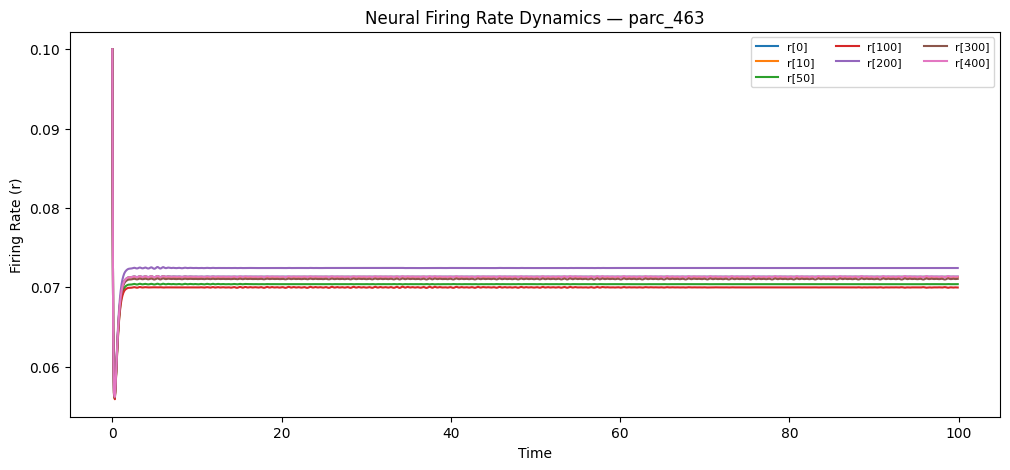

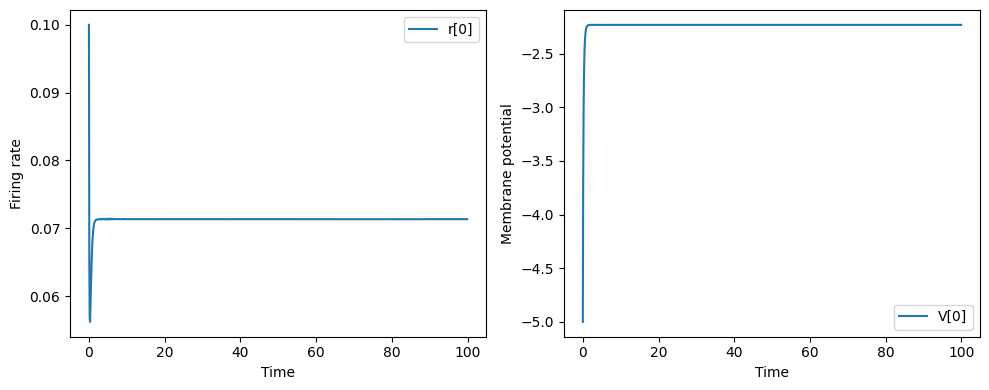

In [28]:
plt.figure(figsize=(12, 5))
for idx in [0, 10, 50, 100, 200, 300, 400]:
    plt.plot(t, r[idx], label=f"r[{idx}]")

plt.xlabel("Time")
plt.ylabel("Firing Rate (r)")
plt.title("Neural Firing Rate Dynamics — parc_463")
plt.legend(ncol=3, fontsize=8)
plt.show()

# Optional: detailed voltage and firing rate of one region
neurocore.plot(t, r, V, region_idx=0)

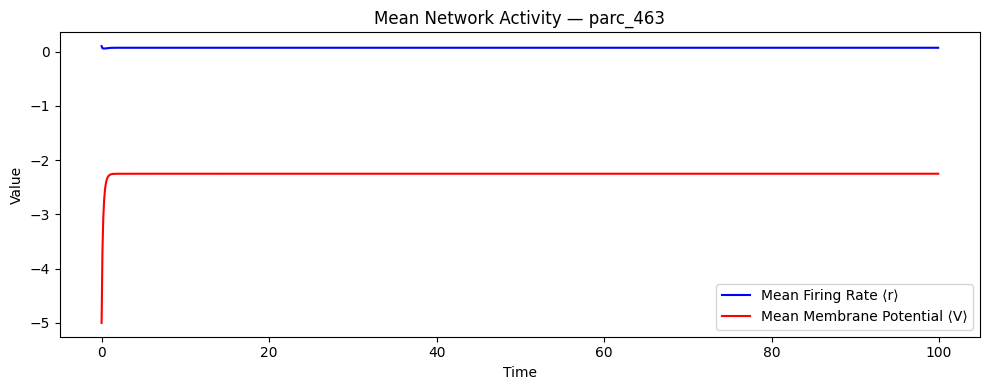

Final mean firing rate ⟨r⟩: 0.0707
Final mean membrane potential ⟨V⟩: -2.2510


In [29]:
# ============================================================
# 🔍 Compute Mean Firing Rate and Mean Membrane Potential
# ============================================================

mean_r = np.mean(r, axis=0)  # average across all regions over time
mean_V = np.mean(V, axis=0)

plt.figure(figsize=(10, 4))
plt.plot(t, mean_r, label="Mean Firing Rate ⟨r⟩", color='blue')
plt.plot(t, mean_V, label="Mean Membrane Potential ⟨V⟩", color='red')
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Mean Network Activity — parc_463")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Final mean firing rate ⟨r⟩: {mean_r[-1]:.4f}")
print(f"Final mean membrane potential ⟨V⟩: {mean_V[-1]:.4f}")
